### Segway Simulation
The system is comprised of a simple wheel and rod. A moment caused by gravity is the cause of error in the system.
- $d$: the horizontal distance from the rods center of gravity to the support.
- $\theta$: the angle the rod is off the vertical. This angle is error and should be minimized.
- $m$: mass of the system
- $g$: acceleration due to gravity
- $L$: Length of the rod
- $r$: Radius of the wheel
- $N$: Horizontal correcting force as a result of the wheel
- $M_m$: Torque produced by the motor
- $k$: Coefficient of friction in the rotation of the rod
- $u_s$: Coefficient of static friction between the wheel and the ground

$$\sum{M_o}=hN - dF_g = N\frac{L}{2}cos\theta - mg\frac{L}{2}sin\theta$$

The moment of inertia ($I$) of a rod is $I=\frac{1}{3}mL^2$ at the tip and $I=\frac{1}{12}mL^2$ around it's center. Because we are unsure where the center of mass will lie on the rod, we will generalize this to be $I=AmL^2$ This means reduces the system the an ODE:

$$\sum{M_o}=I\frac{d^2 \theta}{dt^2}$$
$$N\frac{L}{2}cos\theta - mg\frac{L}{2}sin\theta=AmL^2\frac{d^2 \theta}{dt^2}$$

Python can't handle the double derivative, so we must convert this into a state-space representation (a system of ODEs):

$$w=\frac{d\theta}{dt}$$
$$\frac{Ncos\theta}{2AmL} - \frac{gsin\theta}{2AL}=\frac{dw}{dt}$$
$$\frac{d}{dt}\binom{\theta}{w}=\binom{w}{\frac{Ncos\theta}{2AmL} - \frac{gsin\theta}{2AL}}$$

With no controlling for $N$, the state space reduces to:

$$\frac{d}{dt}\binom{\theta}{w}=\binom{w}{-\frac{gsin\theta}{2AL}}$$

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

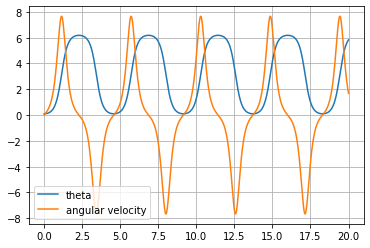

In [17]:
# State Space Representation
def simple_state_space(y: list, t: float, g=9.81, L=1, A=1/3): # [theta, angular velocity]
    # System is time invariant, so it doesn't depend on t (timestep)
    theta, w = y
    dtheta = w
    dw = g/(2*A*L)*np.sin(theta)
    return dtheta, dw

ts = np.linspace(0, 20, 1000)

ys = odeint(simple_state_space, y0=(0.1, 0), t=ts) # Run simulation
thetas, ws = ys.T
ys = np.cos(thetas) # Peak of the rod

# Plot the numerical solution
plt.grid()
plt.plot(ts, thetas)
plt.plot(ts, ws)
plt.legend(('theta', 'angular velocity'))
plt.show()

### Friction and Control
Since this is a real system, we will encounter friction. $F$ is the friction in the system, slowling down the angular velocity. It is dependent on the angular velocity and a coefficient of friction $k$
$$\sum{M_o} = AmL^2\frac{d^2 \theta}{dt^2} = N\frac{L}{2}cos\theta - mg\frac{L}{2}sin\theta - kw$$

$N$ will attempt to minimize the error ($\theta$) in the fastest and most stable way possible. N is created by the wheel; this means there is a torque $M_m$ at a distance $r$ from the ground that generates a friction force between the ground and the wheel ($N=r*M_m$). Since we are using friction, we must make sure this horizontal force is below the $F_max=u_s mg$ or the wheel will slip. Using the state-space representation, we get:

$$\frac{d}{dt}\binom{\theta}{w}=\binom{w}{\frac{g}{2AL}sin\theta - \frac{rcos\theta}{AmL}M_m(\theta) - \frac{kw}{AmL}}$$



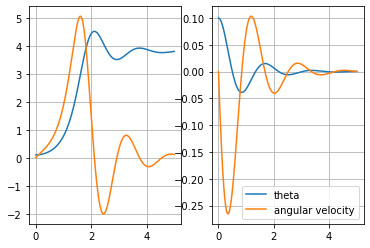

In [26]:
# Expample control loop (simply proportional to error)
def M(theta, a=10):
    return a*theta

# State Space Representation
def system_ode(y: list, t: float, g=9.81, L=1, m=1, k=0.75, A=1/3, r=0.1, a=10): # [theta, angular velocity]
    # System is time invariant, so it doesn't depend on t (timestep)
    theta, w = y
    M_m = M(theta, a=a)
    dtheta = w
    dw = g/(2*A*L)*np.sin(theta) - (r*M_m*np.cos(theta))/(m*A*L) - k*w/(m*A*L)
    return dtheta, dw

ts = np.linspace(0,5,1000)

ys = odeint(system_ode, y0=(0.1, 0), t=ts) # Resultant thetas

ys2 = odeint(lambda y, t: system_ode(y, t, a=100), y0=(0.1, 0), t=ts) # Resultant thetas

# Plot the numerical solution
fig, axs = plt.subplots(1, 2)
axs[0].grid()
axs[0].plot(ts, ys)
axs[1].grid()
axs[1].plot(ts, ys2)
plt.legend(('theta', 'angular velocity'))
plt.show()

$M$ will most likely be implemented using a PID controller. The generic formula for PID is:
$$M(\theta)=K_{p}\theta+K_{i}\int_{0}^{t}\theta(\tau)d\tau\ +\ K_{d}\frac{d\theta}{dt}$$

Check out `sim.py` for the implementation of this system.